# § 1 Introduction

### Key points from the paper

> ...a general-purpose agent which we call Gato, instantiated as a single, large, transformer sequence model.

> We focus our training at the operating point of model scale that allows real-time control of real-world robots, currently around 1.2B parameters in the case of Gato.

> To enable processing this multi-modal data, we serialize all data into a flat sequence of tokens.

My personal summary:

This is just a plain old transformer. Nothing new about the architecture.

The new stuff (and the most finicky to get right) is in tokenizing, sequencing, and assigning loss values to the different modalities.

We're going to try to make that new stuff as clear and simple as possible.

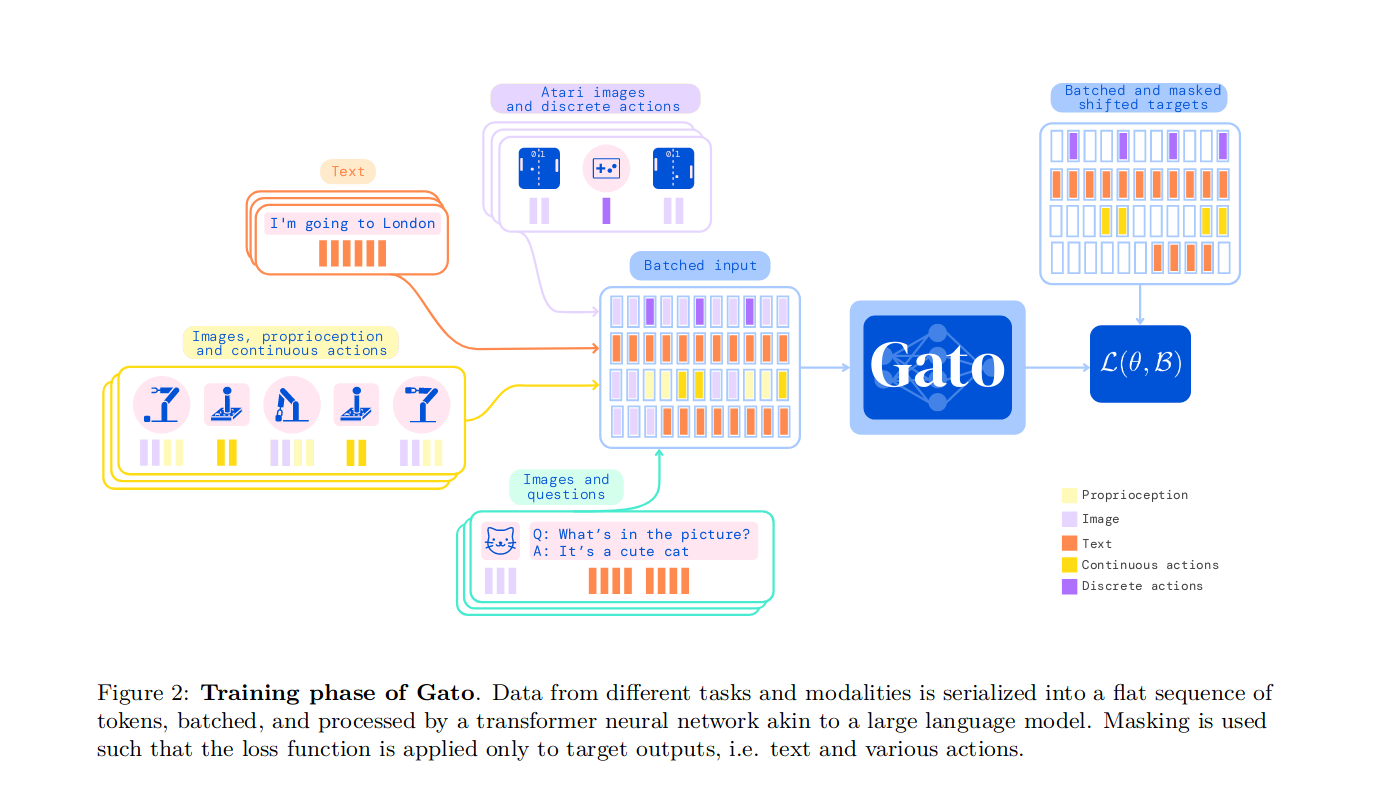

# § 2.1 Tokenization

> There are infinite possible ways to transform data into tokens, including directly using the raw underlying byte stream. Below we report the tokenization scheme we found to produce the best results for Gato at the current scale using contemporary hardware and model architectures.

This is the best scheme they found. It would be interesting to see if recent advancements open up any new options.

> Text is encoded via SentencePiece (Kudo & Richardson, 2018) with 32000 subwords into the integer range [0, 32000).

> Images are first transformed into sequences of non-overlapping 16 × 16 patches in raster order, as done in ViT (Dosovitskiy et al., 2020). Each pixel in the image patches is then normalized between [−1, 1] and divided by the square-root of the patch size (i.e. √16 = 4).

> Discrete values, e.g. Atari button presses, are flattened into sequences of integers in row-major order. The tokenized result is a sequence of integers within the range of [0, 1024).

> Continuous values, e.g. proprioceptive inputs or joint torques, are first flattened into sequences of floating point values in row-major order. The values are mu-law encoded to the range [−1, 1] if not already there (see Figure 14 for details), then discretized to 1024 uniform bins. The discrete integers are then shifted to the range of [32000, 33024).

Let's dive in.

Our plan of attack is going to be to grab some very small datasets. We want to be able to move fast while we explore. We want small datasets and small models. Once we have a proof of concept, scaling up the size of our data and models will be a relatively simple and isolated task. We don't expect it to require any significant changes to the prior work we'll have done.

## Datasets

Let's grab datasets from a few different locations so that we can explore the process of translating a variety of datasets to a unified interface.

First, an overview of PyTorch Datasets and DataLoaders.

### Dataset

A couple of things to remember:

1. We might be working with large datasets. We need to consider how much memory we'll be consuming.

> If your Dataset loads the data lazily in __getitem__ each worker in your DataLoader will load one complete batch into memory.
> 
> \- https://discuss.pytorch.org/t/how-to-use-dataset-larger-than-memory/37785/4

2. If random reads are expensive, we might need to work with an IterableDataset, which has a few of its own caveats.

> This type of datasets is particularly suitable for cases where random reads are expensive or even improbable, and where the batch size depends on the fetched data.
>
> For example, such a dataset, when called iter(dataset), could return a stream of data reading from a database, a remote server, or even logs generated in real time.
>
> When using a IterableDataset with multi-process data loading. The same dataset object is replicated on each worker process, and thus the replicas must be configured differently to avoid duplicated data. See IterableDataset documentations for how to achieve this.
>
> \- https://pytorch.org/docs/stable/data.html#iterable-style-datasets

### DataLoader

> Data loader combines a dataset and a sampler, and provides an iterable over the given dataset.
> 
> The DataLoader supports both map-style and iterable-style datasets with single- or multi-process loading, customizing loading order and optional automatic batching (collation) and memory pinning.
> 
> See [torch.utils.data](https://pytorch.org/docs/stable/data.html#loading-batched-and-non-batched-data) documentation page for more details.
> 
> \- https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader

## What do we want our DataLoader to provide?

What kind of work should we do in the DataLoader? What kind of work should be the responsibility of the model?

It would be nice if the model could just take elements from the DataLoader and send them straight through to `model.forward(...)`.

And it would be nice if `model.forward(...)` could treat everything it received exactly the same.

By that, I mean, it would be nice if `model.forward(...)` receives the embeddings themselves.

If `model.forward(...)` doesn't receive the embeddings, if it receives the pixels of an image and the tokens of text, etc... then our model is going to need to handle conditionally branching off and performing a bunch of different types of tasks.

If our Datasets handled the embedding work, then our model remains simple.

This _does_ make our Dataset code a little more complex. But each dataset can be worked on in isolation. I think that's a fair trade-off.

### Embeddings...

Let's proceed with the goal of getting our Datasets to provide embeddings. We'll deal with whatever challenges that entails as they appear.

## Text Dataset


There's a popular dataset of 40,000 lines of Shakespeare's plays.

It's good because it's small (in comparison to something like wikitext), and it will be pretty obvious if training succeeds, because Shakespeare's writing is quite identifiable. And it might be fun to hear a picture of a tennis court described in the words of Shakespeare.


In the [words of Karpathy](https://karpathy.github.io/2019/04/25/recipe/#1-become-one-with-the-data):

> Become one with the data.

Take a look at the [raw data](https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt) so you know what we're working with.

> ANTONIO:
> We two, my lord,
> Will guard your person while you take your rest,
> And watch your safety.
> 
> ALONSO:
> Thank you. Wondrous heavy.
> 
> SEBASTIAN:
> What a strange drowsiness possesses them!
> 
> ANTONIO:
> It is the quality o' the climate.
> 
> SEBASTIAN:
> Why
> Doth it not then our eyelids sink? I find not
> Myself disposed to sleep.

Each character's lines are separated by an empty line.

We want our training data to have a long enough context to learn from entire conversations of multiple characters. So, we don't want our DataLoader to return samples of 1 character speaking. That would be too short.

I suggest we split on each character's lines and then take a number of character's lines in sequence until we have more than ~250 words. That ought to play nicely with a sequence length of 512. And if we want to play with smaller sequence lengths, we can always truncate. (And larger sequence lengths we'll just pad.)

In [1]:
import os
from pathlib import Path
import re
import tempfile
import requests

temp_dir = tempfile.gettempdir()
shakespeare_filepath = Path(temp_dir)/"shakespeare.txt"
if not os.path.exists(shakespeare_filepath):
    data_url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
    with open(shakespeare_filepath, 'w', encoding='utf-8') as f:
        f.write(requests.get(data_url).text)

with open(shakespeare_filepath, 'r', encoding='utf-8') as f:
    data = f.read()

characters_lines = re.split(r"\n\s*\n", data.strip())

In [2]:
print(data[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [3]:
MIN_WORDS_PER_BATCH = 250
sample = [characters_lines[0]]
num_words_in_sample = len(characters_lines[0].split())
text_dataset = []
i = 1
while i < len(characters_lines[:100]):
    if num_words_in_sample > MIN_WORDS_PER_BATCH:
        text_dataset.append("\n\n".join(sample))
        num_words_in_sample -= len(sample[0].split())
        sample = sample[1:]
    sample += [characters_lines[i]]
    num_words_in_sample += len(characters_lines[i].split())
    i += 1

In [4]:
text_dataset[:2]

["First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you know Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us kill him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be done: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citizens, the patricians good.\nWhat authority surfeits on would relieve us: if they\nwould yield us but the superfluity, while it were\nwholesome, we might guess they relieved us humanely;\nbut they think we are too dear: the leanness that\nafflicts us, the object of our misery, is as an\ninventory to particularise their abundance; our\nsufferance is a gain to them Let us revenge this with\nour pikes, ere we become rakes: for the gods know I\nspeak this in hunger

That seems reasonable.

Now to tokenize it.

The Gato paper encodes text via SentencePiece.

We're going to deviate slightly from the paper here. We're going to use th GPT2Tokenizer from HuggingFace `transformers` library. It's convenient. We'll also be using the [GPT2Model](https://huggingface.co/docs/transformers/en/model_doc/gpt2) (eventually, when we get to that point), so it seems reasonable to just remain in that ecosystem for the tokenizer as well.

In [5]:
from transformers import GPT2TokenizerFast

In [6]:
text_tokenizer = GPT2TokenizerFast.from_pretrained("openai-community/gpt2")
text_tokenizer.pad_token = text_tokenizer.eos_token

In [7]:
import torch

In [8]:
CONTEXT_WINDOW = 1024

def tokenize(sample):
    tokenized = text_tokenizer(
        sample, truncation=True, padding="max_length", max_length=CONTEXT_WINDOW, return_tensors="pt"
    )
    return {
        "input_ids": tokenized["input_ids"].squeeze(0),
        "attention_mask": tokenized["attention_mask"].squeeze(0),
    }

In [9]:
from torch.utils.data import DataLoader

In [10]:
text_dataloader = DataLoader(list(map(tokenize, text_dataset)), batch_size=8, shuffle=True)
text_batch = next(iter(text_dataloader))

In [11]:
print(text_batch["input_ids"].shape)
print(text_batch["input_ids"][0][:10])
print(text_batch["attention_mask"][0][:10])
print(text_batch["input_ids"][0][-10:])
print(text_batch["attention_mask"][0][-10:])

torch.Size([8, 1024])
tensor([ 5962, 22307,    25,   198,  5122,  1597,   318,   407,  6439,   284])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
tensor([50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


Sweet. That all looks good. We've got our text tokens.

Let's move on to images.

## Image and Questions Dataset

I happen to know of a very small VQA dataset on HuggingFace that we can use for question and answering about images.

In [12]:
import datasets

In [13]:
vqa_dataset = datasets.load_dataset("eihli/micro-ok-vqa").with_format(
    "torch"
)

Once again, in the [words of the greatKarpathy](https://karpathy.github.io/2019/04/25/recipe/#1-become-one-with-the-data)...

> Become one with the data.

Let's explore

In [14]:
vqa_dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'question_type', 'confidence', 'answers', 'image_id', 'answer_type', 'question_id', 'question'],
        num_rows: 80
    })
    validation: Dataset({
        features: ['image', 'question_type', 'confidence', 'answers', 'image_id', 'answer_type', 'question_id', 'question'],
        num_rows: 20
    })
})

In [15]:
vqa_dataset["train"]

Dataset({
    features: ['image', 'question_type', 'confidence', 'answers', 'image_id', 'answer_type', 'question_id', 'question'],
    num_rows: 80
})

In [16]:
len(vqa_dataset["train"]["image"]), vqa_dataset["train"]["image"][0].shape

(80, torch.Size([479, 640, 3]))

So, we've got 80 training images. They don't appear to be in any particularly standardized size. And they seem to be in a (height, width, channel) rank.

That's the rank that `matplotlib.pyplot.imshow` expects. But I think most PyTorch image-related functions expect (channel, height, width). So we'll have to permute that.

We'll also need to make them all the same shape. We can use PyTorch [transforms](https://pytorch.org/vision/stable/transforms.html) for that.

In [17]:
import matplotlib.pyplot as plt

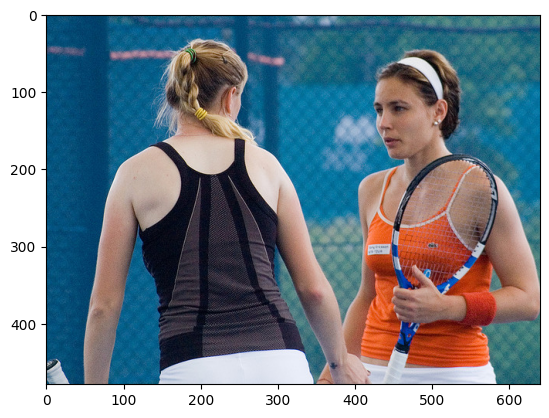

In [18]:
plt.imshow(vqa_dataset["train"]["image"][0])

In [19]:
import torchvision.transforms.v2 as transforms

In [30]:
def _permute_channel_to_first(sample):
    sample["image"] = torch.permute(sample["image"], (2, 0, 1))
    return sample

transform = transforms.Compose([
    _permute_channel_to_first,    
    transforms.RandomResizedCrop((256, 256)),
])

In [31]:
vqa_dataloader = DataLoader(
    vqa_dataset["train"]
    .map(transform),
    batch_size=8,
)
vqa_batch = next(iter(vqa_dataloader))

In [34]:
vqa_batch["image"].shape

torch.Size([8, 3, 256, 256])

Sweet.

Now.

How do we tokenize images?

> Images are first transformed into sequences of non-overlapping 16 × 16 patches in raster order, as done in ViT (Dosovitskiy et al., 2020). Each pixel in the image patches is then normalized between [−1, 1] and divided by the square-root of the patch size (i.e. √16 = 4).

## Robotics Dataset

Another one that's relatively small and easy to grab from HuggingFace.

[cartpole](https://huggingface.co/datasets/ml-frameworks/cartpole)

> Description
> 
> The dataset consists of 1,000 episodes with an average episodic reward of 500. Each entry consists of:
> 
> obs (list): observation with length 4.
> action (int): action (0 or 1).
> reward (float): reward point for that timestep.
> episode_returns (bool): if that state was the initial timestep for an episode.


In [40]:
cartpole_dataset = datasets.load_dataset("ml-frameworks/cartpole").with_format("torch")

In [41]:
cartpole_dataset

DatasetDict({
    train: Dataset({
        features: ['observation', 'action', 'next_observation', 'reward', 'discount'],
        num_rows: 500000
    })
})

In [43]:
cartpole_dataset["train"]["observation"].shape

torch.Size([500000, 4])

In [46]:
cartpole_dataset["train"]["observation"][0], cartpole_dataset["train"]["next_observation"][0]

(tensor([-1.1612, -1.9998, -0.1310, -0.1571]),
 tensor([-1.2012, -2.1928, -0.1342,  0.0915]))

How does Gato handle continous values like this?

> Continuous values, e.g. proprioceptive inputs or joint torques, are first flattened into sequences of floating point values in row-major order. The values are mu-law encoded to the range [−1, 1] if not already there (see Figure 14 for details), then discretized to 1024 uniform bins. The discrete integers are then shifted to the range of [32000, 33024).

In [45]:
cartpole_dataset["train"]["observation"][1]

tensor([-1.2012, -2.1928, -0.1342,  0.0915])